# **IMPORT LIBRARY**

In [30]:
# Import Library
import pandas as pd
## Preprocessing text
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
## Pelabelan
from nltk.corpus import opinion_lexicon
## Eksploarsi Label
from wordcloud import WordCloud
import matplotlib.pyplot as plt
## Splitting Data dan Ekstraksi Fitur
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
## Modeling
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# **LOAD DATASET**

In [31]:
# Load file CSV hasil scraping
url = "https://raw.githubusercontent.com/heriswaya/Sentiment-Analysis-Dicoding/main/ulasan_alibaba.csv"

# Load data ke DataFrame
app_reviews_df = pd.read_csv(url)

# Tampilkan informasi awal
print("Jumlah ulasan:", app_reviews_df.shape[0])
app_reviews_df.head()

Jumlah ulasan: 99000


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,27bf1c05-2d55-434b-8008-790a160016cd,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The app is great. I run a pretty good sized co...,5,5262,8.82.0,2025-03-15 18:38:47,NaN,NaN,8.82.0
1,69f9cd05-17e7-4459-92dd-b915fe959e0f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The app doesn't work properly. Firstly it tell...,2,1985,8.77.0,2025-01-25 21:37:16,We are sorry for your experience. If you have ...,2025-02-06 02:20:34,8.77.0
2,1d6cb16d-c070-4db3-8dc9-8bb7ba86cb37,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The apps functionality seriously sucks.... Sea...,1,3539,8.71.1,2024-12-02 13:06:25,We are sorry for your experience. If you have ...,2024-12-03 01:23:10,8.71.1
3,c83c1e64-6aa3-42e8-9a56-0385a297b87b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Buyer beware! They have tons of listings that ...,1,2871,7.26.2,2021-01-25 04:11:00,NaN,NaN,7.26.2
4,ef5a3285-4849-4fe8-8855-e8315f07ebd9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"The items are great, but when I click on one o...",2,15608,8.28.0,2023-10-23 05:10:01,"Hi, we are sorry to hear that. Do share additi...",2023-11-10 11:05:44,8.28.0


In [32]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99000 entries, 0 to 98999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              99000 non-null  object
 1   userName              99000 non-null  object
 2   userImage             99000 non-null  object
 3   content               99000 non-null  object
 4   score                 99000 non-null  int64 
 5   thumbsUpCount         99000 non-null  int64 
 6   reviewCreatedVersion  75808 non-null  object
 7   at                    99000 non-null  object
 8   replyContent          10441 non-null  object
 9   repliedAt             10441 non-null  object
 10  appVersion            75808 non-null  object
dtypes: int64(2), object(9)
memory usage: 8.3+ MB


In [33]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari app_reviews_df
clean_df = app_reviews_df.dropna()

# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

In [34]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6961 entries, 1 to 98948
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              6961 non-null   object
 1   userName              6961 non-null   object
 2   userImage             6961 non-null   object
 3   content               6961 non-null   object
 4   score                 6961 non-null   int64 
 5   thumbsUpCount         6961 non-null   int64 
 6   reviewCreatedVersion  6961 non-null   object
 7   at                    6961 non-null   object
 8   replyContent          6961 non-null   object
 9   repliedAt             6961 non-null   object
 10  appVersion            6961 non-null   object
dtypes: int64(2), object(9)
memory usage: 652.6+ KB


# **PREPROCESSING TEXT**

In [35]:
# Download data NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
# Inisialisasi stemmer dan stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [37]:
# Function: Membersihkan teks
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # remove mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # remove hashtags
    text = re.sub(r'RT[\s]+', '', text)        # remove RT
    text = re.sub(r"http\S+", '', text)        # remove links
    text = re.sub(r'[0-9]+', '', text)         # remove numbers
    text = re.sub(r'[^\x00-\x7F]+', ' ', text) # remove non-ASCII (emoji, simbol asing)
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    return text

# Funtion: Mengubah semua karakter dalam teks menjadi huruf kecil
def casefoldingText(text):
    text = text.lower()
    return text

# Function: Tokenizing
def tokenizingText(text):
    return word_tokenize(text)

# Function: Stopword removal
def filteringText(tokens):
    return [word for word in tokens if word not in stop_words]

# Function: Stemming
def stemmingText(tokens):
    return [stemmer.stem(word) for word in tokens]

# Function: Ubah token jadi kalimat lagi
def toSentence(tokens):
    return ' '.join(tokens)

# Function: Ubah slangwords ke kata aslinya
slangwords = {
    # Common slang
    "u": "you",
    "ur": "your",
    "r": "are",
    "ya": "you",
    "thx": "thanks",
    "pls": "please",
    "im": "i am",
    "idk": "i do not know",
    "lol": "laugh out loud",
    "btw": "by the way",
    "omg": "oh my god",
    "b4": "before",
    "cuz": "because",
    "wanna": "want to",
    "gonna": "going to",
    "gotta": "got to",
    "aint": "am not",
    "luv": "love",

    # Extended list
    "2day": "today",
    "2moro": "tomorrow",
    "2nite": "tonight",
    "4ever": "forever",
    "4u": "for you",
    "afaik": "as far as i know",
    "asap": "as soon as possible",
    "atm": "at the moment",
    "b": "be",
    "bc": "because",
    "bday": "birthday",
    "brb": "be right back",
    "bro": "brother",
    "bros": "brothers",
    "cm": "call me",
    "dunno": "do not know",
    "dwiw": "deal with it",
    "fyi": "for your information",
    "gg": "good game",
    "gl": "good luck",
    "gr8": "great",
    "hbu": "how about you",
    "hf": "have fun",
    "hmu": "hit me up",
    "ic": "i see",
    "icymi": "in case you missed it",
    "idc": "i do not care",
    "ikr": "i know right",
    "ily": "i love you",
    "imo": "in my opinion",
    "irl": "in real life",
    "jk": "just kidding",
    "k": "okay",
    "kk": "okay",
    "lemme": "let me",
    "m8": "mate",
    "msg": "message",
    "n": "and",
    "nvm": "never mind",
    "ofc": "of course",
    "omw": "on my way",
    "pov": "point of view",
    "ppl": "people",
    "qt": "cutie",
    "rofl": "rolling on the floor laughing",
    "sry": "sorry",
    "sup": "what's up",
    "tbh": "to be honest",
    "tmi": "too much information",
    "ttyl": "talk to you later",
    "txt": "text",
    "ty": "thank you",
    "tyt": "take your time",
    "w/": "with",
    "w/o": "without",
    "wbu": "what about you",
    "wyd": "what you doing",
    "xoxo": "hugs and kisses",
    "y": "why",
    "yolo": "you only live once",
    "yw": "you're welcome",

    # Alibaba/e-commerce specific
    "app": "application",
    "plz": "please",
    "thnk": "think",
    "ordr": "order",
    "prod": "product",
    "svc": "service",
    "cust": "customer",
    "deliv": "delivery",
    "disc": "discount",
    "refund": "refund",
    "ship": "shipping",
    "paymnt": "payment",
    "acct": "account",
    "promo": "promotion",
    "qty": "quantity",
    "rply": "reply",
    "trans": "transaction",
    "vry": "very",
    "w8": "wait"
}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        fixed_words.append(slangwords.get(word.lower(), word))
    return ' '.join(fixed_words)

In [38]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [39]:
clean_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
1,69f9cd05-17e7-4459-92dd-b915fe959e0f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The app doesn't work properly. Firstly it tell...,2,1985,8.77.0,2025-01-25 21:37:16,We are sorry for your experience. If you have ...,2025-02-06 02:20:34,8.77.0,The app doesnt work properly Firstly it tells ...,the app doesnt work properly firstly it tells ...,the application doesnt work properly firstly i...,"[the, application, doesnt, work, properly, fir...","[application, doesnt, work, properly, firstly,...",application doesnt work properly firstly tells...
2,1d6cb16d-c070-4db3-8dc9-8bb7ba86cb37,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The apps functionality seriously sucks.... Sea...,1,3539,8.71.1,2024-12-02 13:06:25,We are sorry for your experience. If you have ...,2024-12-03 01:23:10,8.71.1,The apps functionality seriously sucks Searchi...,the apps functionality seriously sucks searchi...,the apps functionality seriously sucks searchi...,"[the, apps, functionality, seriously, sucks, s...","[apps, functionality, seriously, sucks, search...",apps functionality seriously sucks searching i...
4,ef5a3285-4849-4fe8-8855-e8315f07ebd9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"The items are great, but when I click on one o...",2,15608,8.28.0,2023-10-23 05:10:01,"Hi, we are sorry to hear that. Do share additi...",2023-11-10 11:05:44,8.28.0,The items are great but when I click on one of...,the items are great but when i click on one of...,the items are great but when i click on one of...,"[the, items, are, great, but, when, i, click, ...","[items, great, click, one, variation, options,...",items great click one variation options add en...
6,7a65dce8-3f09-4e4e-a263-55efebc13c65,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It's all around a great app except for the fac...,4,4342,6.10.2,2018-12-21 18:25:23,Thanks for your feedback. Could you tell us mo...,2018-01-10 06:01:58,6.10.2,Its all around a great app except for the face...,its all around a great app except for the face...,its all around a great application except for ...,"[its, all, around, a, great, application, exce...","[around, great, application, except, face, sen...",around great application except face send file...
14,b3984ad2-24e5-4a6a-9f50-08c93a4bc7b6,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I concur that this app manipulates the audio d...,1,822,7.44.0,2021-11-19 03:42:39,The problem you reported has been fixed. Pleas...,2021-11-29 06:32:48,7.44.0,I concur that this app manipulates the audio d...,i concur that this app manipulates the audio d...,i concur that this application manipulates the...,"[i, concur, that, this, application, manipulat...","[concur, application, manipulates, audio, driv...",concur application manipulates audio driver st...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98943,bf42df3e-c0f6-4398-8d64-2227ac29a57a,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Nice,2,0,8.73.0,2024-12-18 15:37:00,"Thank you for using Alibaba.com App , any quer...",2024-12-18 16:00:02,8.73.0,Nice,nice,nice,[nice],[nice],nice
98944,70bc15ae-f336-47fb-91af-8b04e6290e01,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Cool,2,0,8.73.0,2025-01-01 10:41:16,"Thank you for using Alibaba.com App , any quer...",2025-01-01 12:00:12,8.73.0,Cool,cool,cool,[cool],[cool],cool
98945,b357ce96-6248-4aeb-9bd4-319031eacfe7,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Great,2,0,8.73.0,2024-12-17 18:06:18,"Thank you for using Alibaba.com App , any quer...",2024-12-17 19:00:07,8.73.0,Great,great,great,[great],[great],great
98946,fdfc3e21-1192-4465-9227-d957414d099f,A Google user,https://play-lh.googleusercontent.com/EGemo

# PELABELAN

In [40]:
# Download data NLTK
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [41]:
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Fungsi untuk menentukan polaritas sentimen
def sentiment_analysis_lexicon_english(text):
    score = 0
    for word in text:
        if word in positive_words:
            score += 1
        elif word in negative_words:
            score -= 1

    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [42]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_english)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    3380
neutral     2143
negative    1438
Name: count, dtype: int64


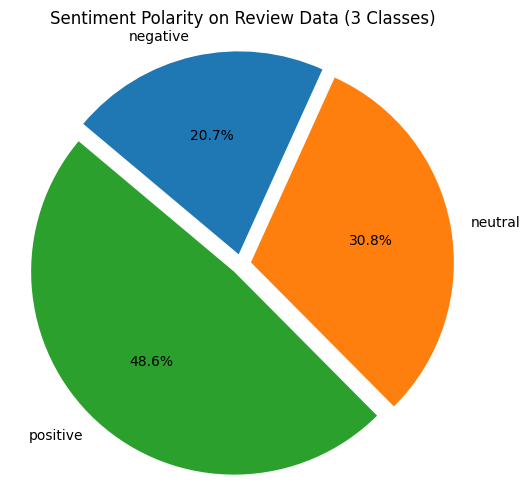

In [43]:
# Hitung jumlah tiap label polarity
label_counts = clean_df['polarity'].value_counts()
labels = label_counts.index
sizes = label_counts.values

# Tambahkan warna untuk 3 kelas
colors = ['#2ca02c', '#ff7f0e', '#1f77b4']  # green, orange, blue

# Tambahkan efek meledak untuk tiap segmen agar visual menarik
explode = [0.05] * len(labels)

# Buat pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140)
plt.title('Sentiment Polarity on Review Data (3 Classes)')
plt.axis('equal')  # Biar lingkaran simetris
plt.show()

# EKSPLORASI LABEL

In [44]:
# Gabungkan semua teks berdasarkan label
positive_text = ' '.join(clean_df[clean_df['polarity'] == 'positive']['text_akhir'])
negative_text = ' '.join(clean_df[clean_df['polarity'] == 'negative']['text_akhir'])
neutral_text = ' '.join(clean_df[clean_df['polarity'] == 'neutral']['text_akhir'])

# Buat WordCloud untuk setiap label
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white', colormap='gray').generate(neutral_text)

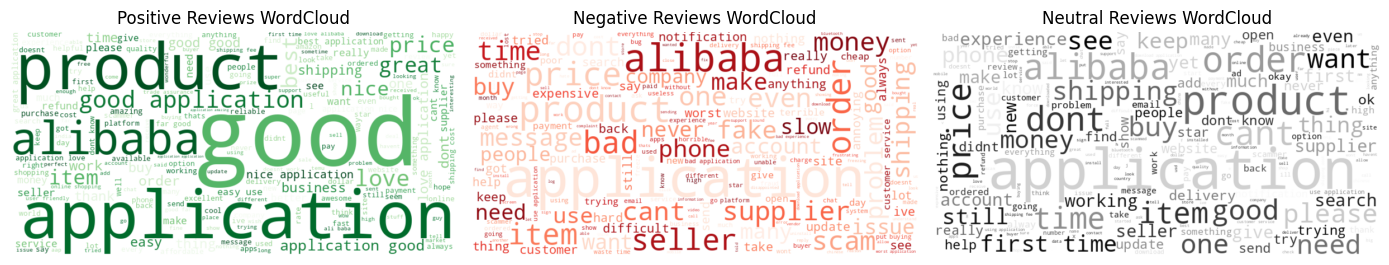

In [45]:
# Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews WordCloud')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews WordCloud')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews WordCloud')
plt.axis('off')

plt.tight_layout()
plt.show()

# DATA SPLITTING DAN EKSTRASI FITUR

In [46]:
# ------------------------------
# Data dasar
X_text = clean_df['text_akhir']         # Teks bersih akhir
y = clean_df['polarity']                # Label sentimen
tokens = clean_df['text_stopword']      # Token untuk Word2Vec
# ------------------------------

# ------------------------------
# Skema 1: TF-IDF + SVM + 80/20
# ------------------------------
tfidf_1 = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
X_tfidf_1 = tfidf_1.fit_transform(X_text)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tfidf_1, y, test_size=0.2, random_state=42)

# ------------------------------
# Skema 2: Word2Vec + RF + 80/20
# ------------------------------
w2v_model = Word2Vec(tokens, vector_size=100, window=5, min_count=1, workers=4)

def avg_vector(tokens):
    vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_w2v = np.array([avg_vector(token_list) for token_list in tokens])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

# ------------------------------
# Skema 3: TF-IDF + RF + 70/30
# ------------------------------
tfidf_3 = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)
X_tfidf_3 = tfidf_3.fit_transform(X_text)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_tfidf_3, y, test_size=0.3, random_state=42)

# MODELING

In [47]:
# ------------------------------
# Skema 1: TF-IDF + SVM + 80/20
# ------------------------------
model1 = SVC()
model1.fit(X_train1, y_train1)

y_pred_train1 = model1.predict(X_train1)
y_pred_test1 = model1.predict(X_test1)

acc_train1 = accuracy_score(y_train1, y_pred_train1)
acc_test1 = accuracy_score(y_test1, y_pred_test1)

print("Skema 1 (TF-IDF + SVM + 80/20)")
print("Akurasi Training :", acc_train1)
print("Akurasi Testing  :", acc_test1)
print()

Skema 1 (TF-IDF + SVM + 80/20)
Akurasi Training : 0.8888290229885057
Akurasi Testing  : 0.7681263460157932



In [48]:
# ------------------------------
# Skema 2: Word2Vec + RF + 80/20
# ------------------------------
model2 = RandomForestClassifier(random_state=42)
model2.fit(X_train2, y_train2)

y_pred_train2 = model2.predict(X_train2)
y_pred_test2 = model2.predict(X_test2)

acc_train2 = accuracy_score(y_train2, y_pred_train2)
acc_test2 = accuracy_score(y_test2, y_pred_test2)

print("Skema 2 (Word2Vec + Random Forest + 80/20)")
print("Akurasi Training :", acc_train2)
print("Akurasi Testing  :", acc_test2)
print()

Skema 2 (Word2Vec + Random Forest + 80/20)
Akurasi Training : 1.0
Akurasi Testing  : 0.6302943287867911



In [49]:
# ------------------------------
# Skema 3: TF-IDF + RF + 70/30
# ------------------------------
model3 = RandomForestClassifier(random_state=42)
model3.fit(X_train3, y_train3)

y_pred_train3 = model3.predict(X_train3)
y_pred_test3 = model3.predict(X_test3)

acc_train3 = accuracy_score(y_train3, y_pred_train3)
acc_test3 = accuracy_score(y_test3, y_pred_test3)

print("Skema 3 (TF-IDF + Random Forest + 70/30)")
print("Akurasi Training :", acc_train3)
print("Akurasi Testing  :", acc_test3)

Skema 3 (TF-IDF + Random Forest + 70/30)
Akurasi Training : 0.9412972085385879
Akurasi Testing  : 0.7501196744853997
